## **Inferring neural progenitor states during indirect neurogenesis from single cell data - scFates** 

(Trevino et al 2021 dataset)

In [1]:
pwd

'/home/jovyan/jm_jlab/data_CBL/indNeuro_tmp/0.scRNA-seq_processing'

### **Loading modules and settings**

In [2]:
import sys
#!{sys.executable} -m pip -q install palantir fa2
import warnings
warnings.filterwarnings("ignore")
from anndata import AnnData
import numpy as np
import pandas as pd
import scanpy as sc
import scFates as scf
import palantir
import matplotlib.pyplot as plt
sc.settings.verbosity = 3
sc.settings.logfile = sys.stdout
## fix palantir breaking down some plots
import seaborn 
seaborn.reset_orig()
%matplotlib inline

sc.set_figure_params()
scf.set_figure_pubready()


from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
from pathlib import Path
Path("/home/jovyan/jm_jlab/data_indNeuro/0.Figures_scRNA-seq_processing/").mkdir(parents=True, exist_ok=True)

In [4]:
figures_path = "/home/jovyan/jm_jlab/data_indNeuro/0.Figures_scRNA-seq_processing/"

### **Loading data with Seurat PCA coordinates and normalization**

filtered out 20719 genes that are detected in less than 50 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts_all', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

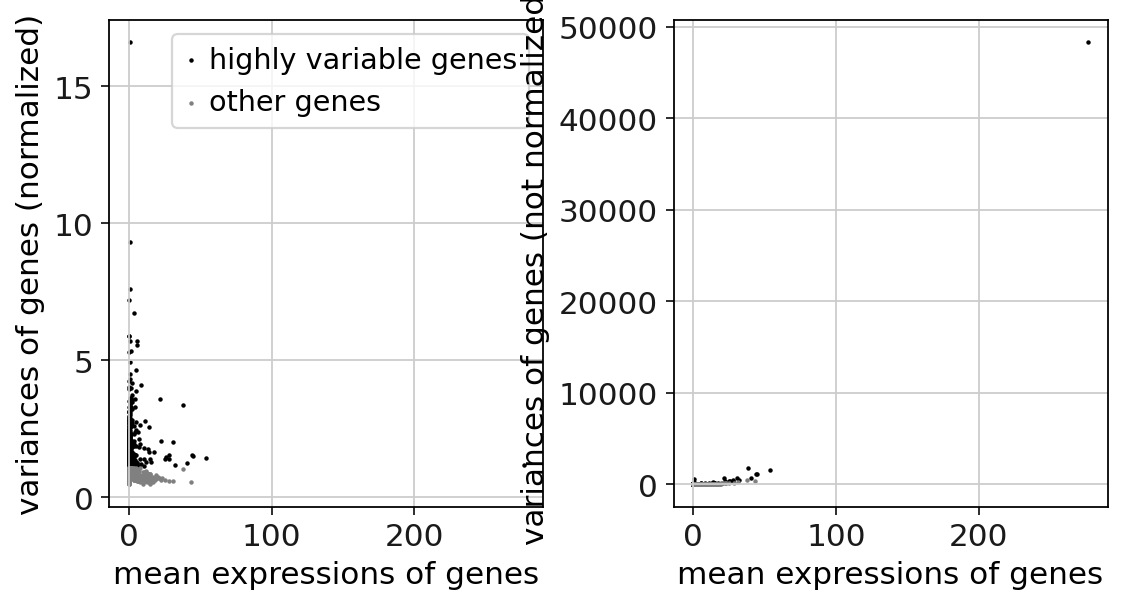

None


In [5]:
adata = sc.read_h5ad("/home/jovyan/jm_jlab/data_indNeuro/intermediate_files/rna_counts.h5ad")

adata.layers['raw_counts'] = adata.X.copy()
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')
sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor='seurat_v3') #let's retain more genes before further filtering
print(sc.pl.highly_variable_genes(adata))

#adata=adata[:,adata.var.highly_variable]
#Renormalized after filtering
#sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')

# keep raw count data before log transformation
adata.raw = adata
adata.layers["raw_count"] = adata.raw.X.copy()

# Log transformation
sc.pp.log1p(adata)

cellembeddings = pd.read_csv("/home/jovyan/jm_jlab/data_indNeuro/intermediate_files/cellembeddings.tsv", sep='\t')
cellembeddings.iloc[:,1] = cellembeddings.iloc[:,1]*-1 #for better geometry
adata.obsm['X_pca'] = cellembeddings.to_numpy() #sharing embeddings

pca_projections = pd.DataFrame(adata.obsm["X_pca"],index=adata.obs_names)

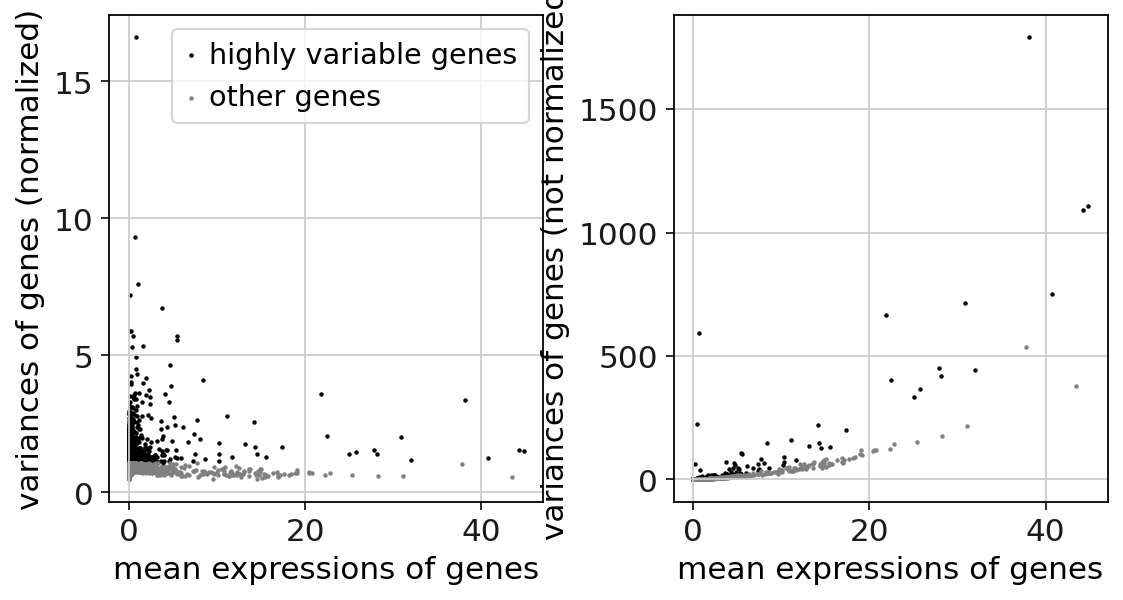

In [6]:
sc.set_figure_params(figsize=(4,4))

sc.pl.highly_variable_genes(adata[:,adata.var['means'] < 50])

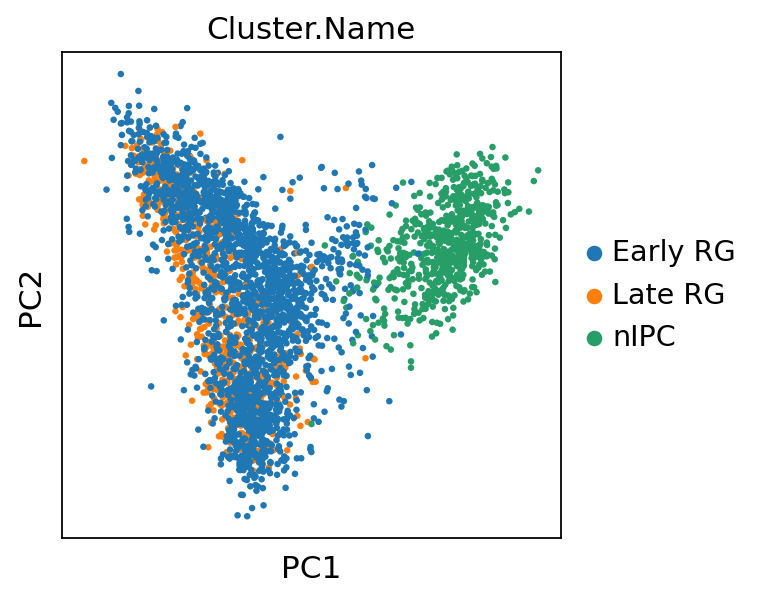

In [7]:
sc.set_figure_params(figsize=(4,4))

sc.pl.pca(adata, color='Cluster.Name')

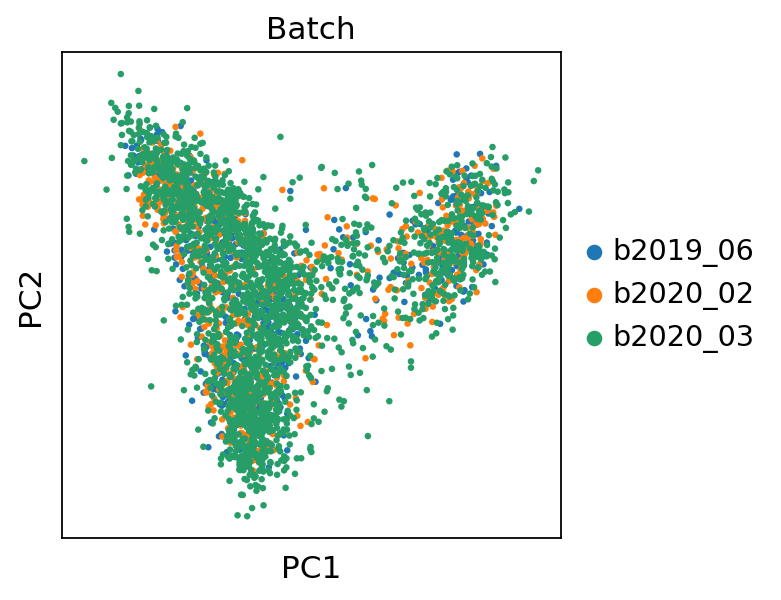

In [14]:
sc.set_figure_params(figsize=(4,4))

sc.pl.pca(adata, color='Batch', alpha=1,  save="SF1_pca_batches.png")

In [11]:
adata.obs['Batch'].value_counts()

b2020_03    2164
b2020_02     709
b2019_06     582
Name: Batch, dtype: int64

**Coarse clustering**

computing neighbors
    using 'X_pca' with n_pcs = 2
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


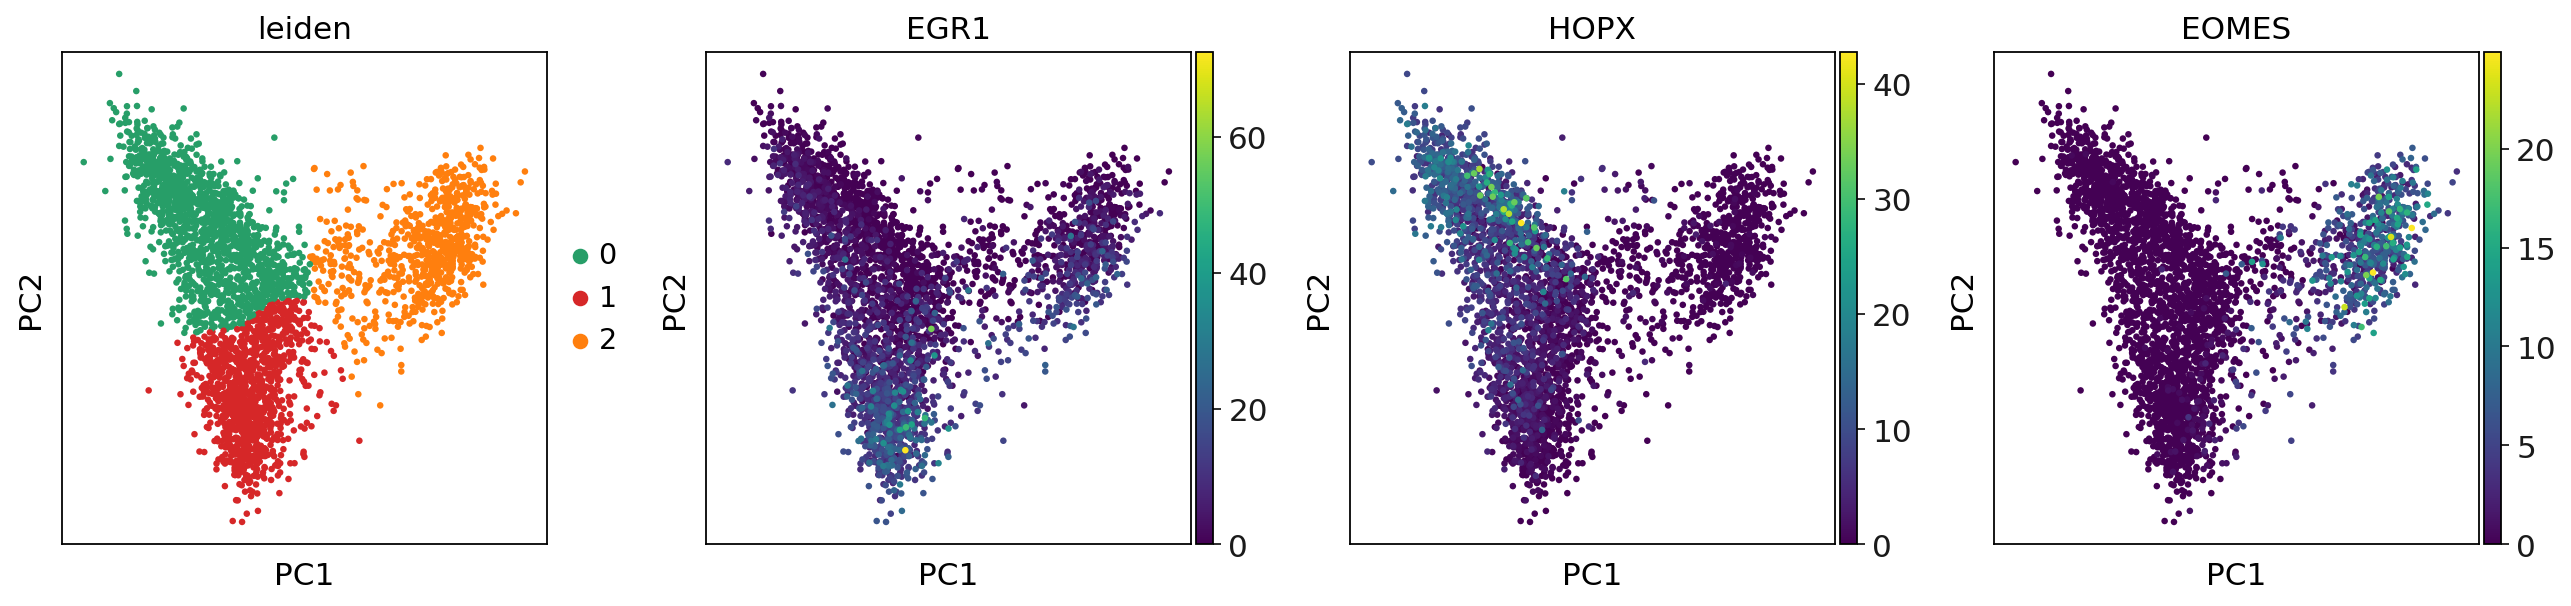

In [13]:
sc.pp.neighbors(adata, n_pcs=2, n_neighbors=75, method='gauss') #Also necessary for later force-directed graph computation

sc.tl.leiden(adata, resolution=0.1) # for coarse clustering

adata.uns['leiden_colors'] = ['#279e68', '#d62728', '#ff7f0e'] # for match with scFates milestones later

sc.pl.pca(adata, color=['leiden', 'EGR1', 'HOPX', 'EOMES'])

In [17]:
import seaborn as sns

In [18]:
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [19]:
sns.color_palette("colorblind",4).as_hex()

['#0173b2', '#de8f05', '#029e73', '#d55e00']

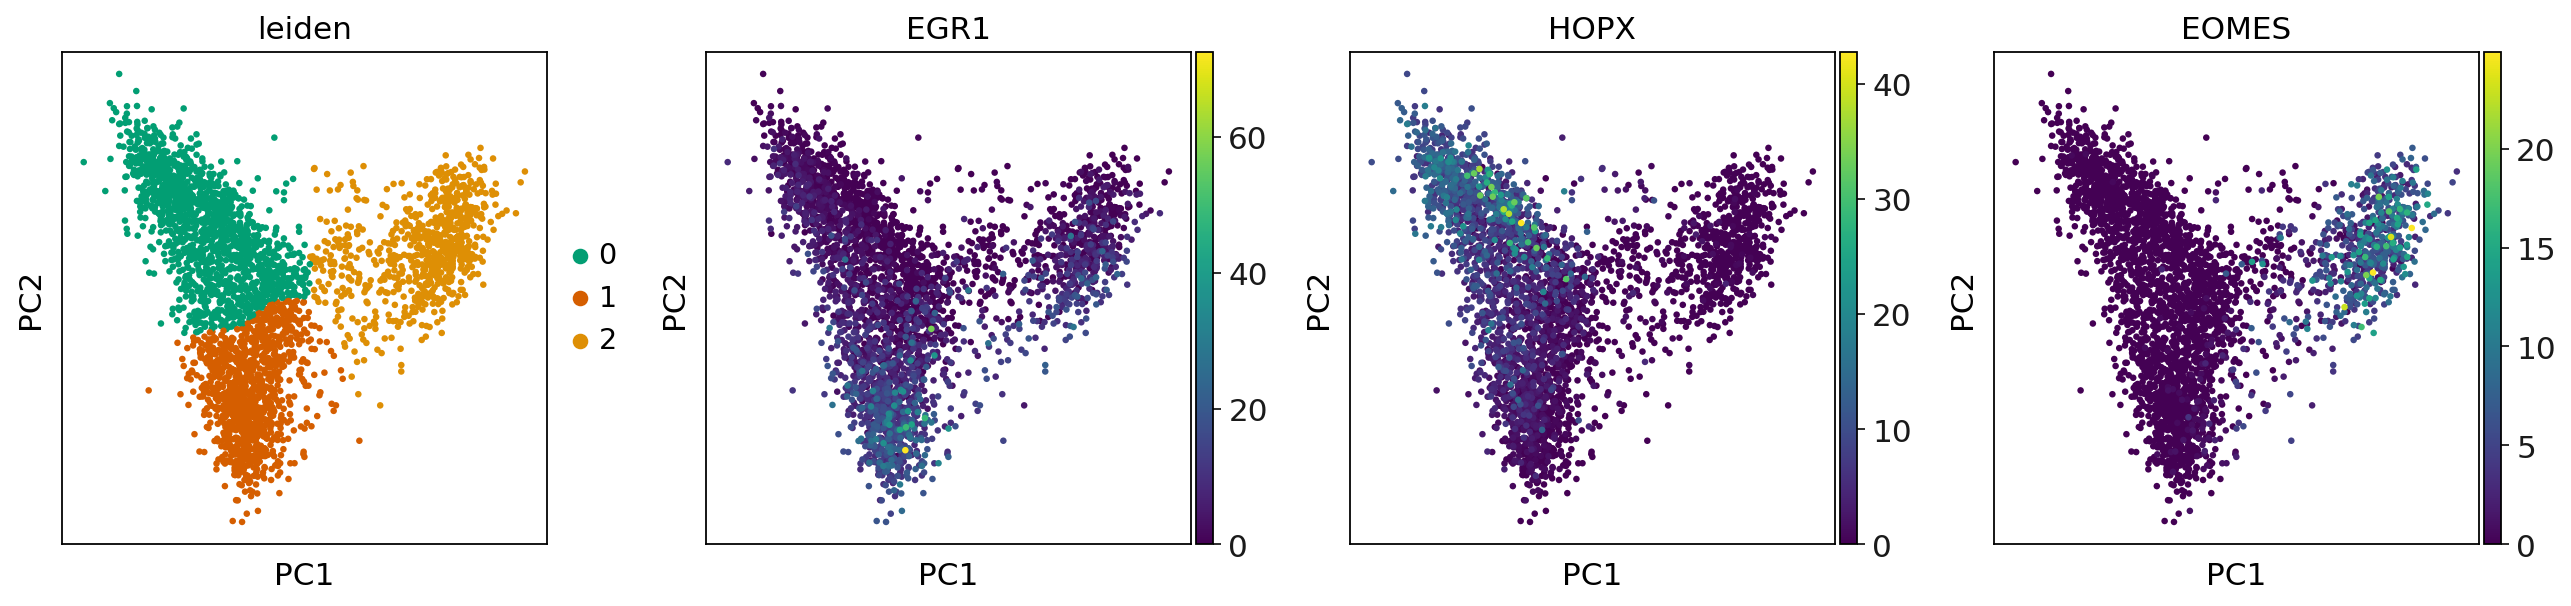

In [20]:
adata.uns['leiden_colors'] = [sns.color_palette("colorblind",4).as_hex()[2], sns.color_palette("colorblind",4).as_hex()[3], sns.color_palette("colorblind",4).as_hex()[1]] # for match with scFates milestones later

sc.pl.pca(adata, color=['leiden', 'EGR1', 'HOPX', 'EOMES'])

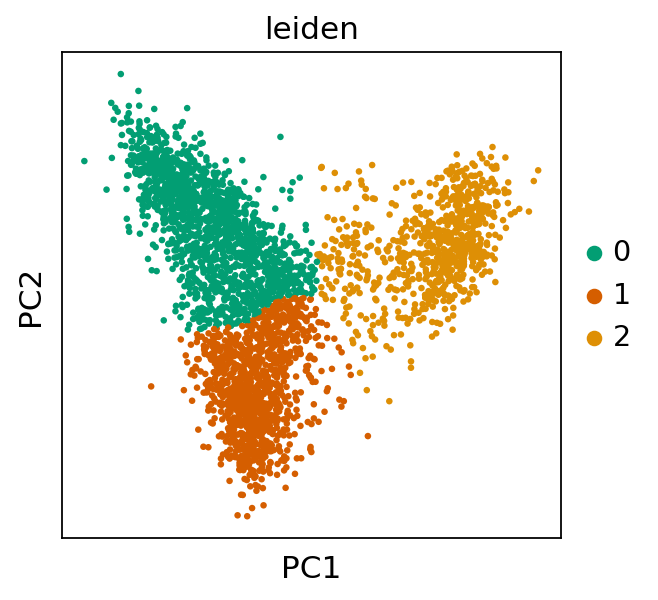

In [26]:
sc.pl.pca(adata, color=['leiden'], save='SF1_CoarseClustering.png')

**DEG - Logistic regression**

In [15]:
# Logistic regression
sc.set_figure_params(figsize=(4, 4),dpi_save=300)

sc.tl.rank_genes_groups(adata, 'leiden', method='logreg', key_added = "logreg")

ranking genes
    finished: added to `.uns['logreg']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:25)


In [22]:
pwd

'/home/jovyan/jm_jlab/data_CBL/indNeuro_tmp/0.scRNA-seq_processing'

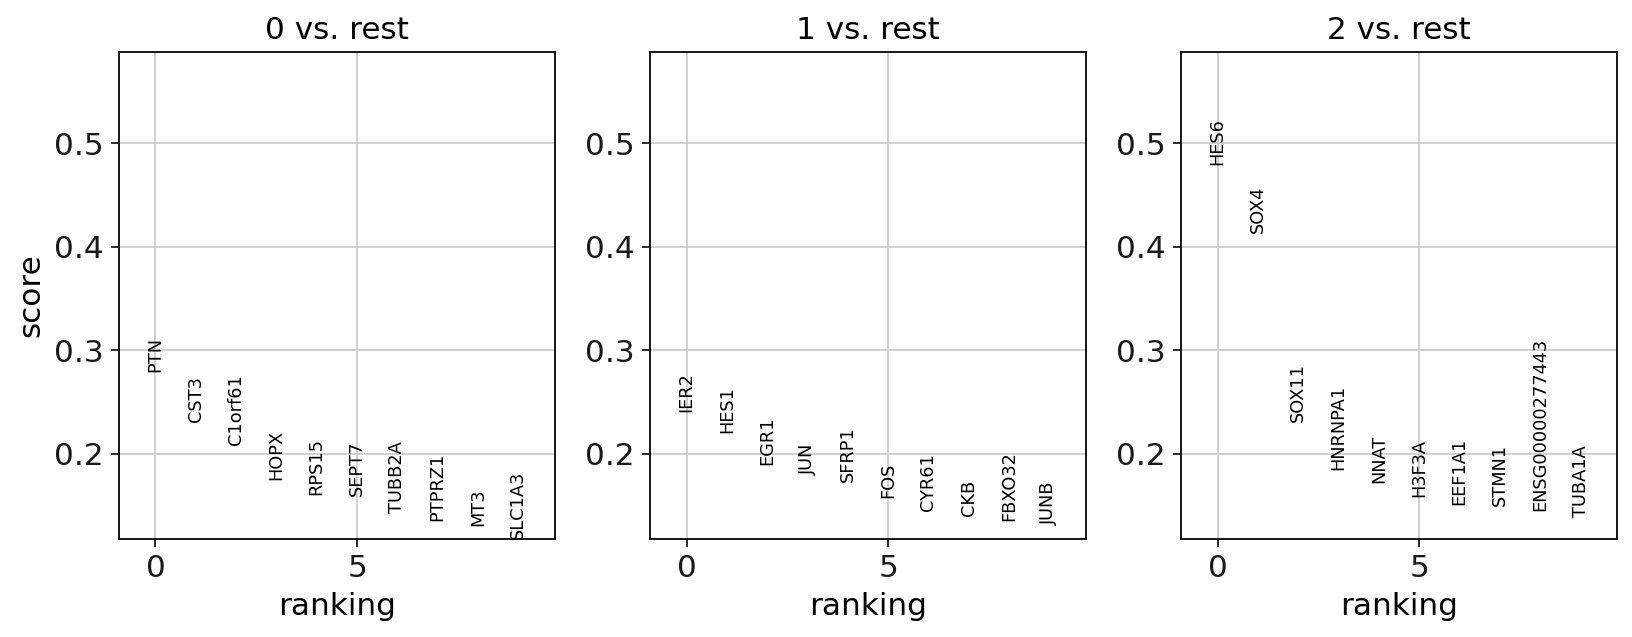

In [25]:
sc.pl.rank_genes_groups(adata,key='logreg', n_genes=10, save="SF1_DEG_logistic.png")

**DEG - Wilcoxon**

ranking genes
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


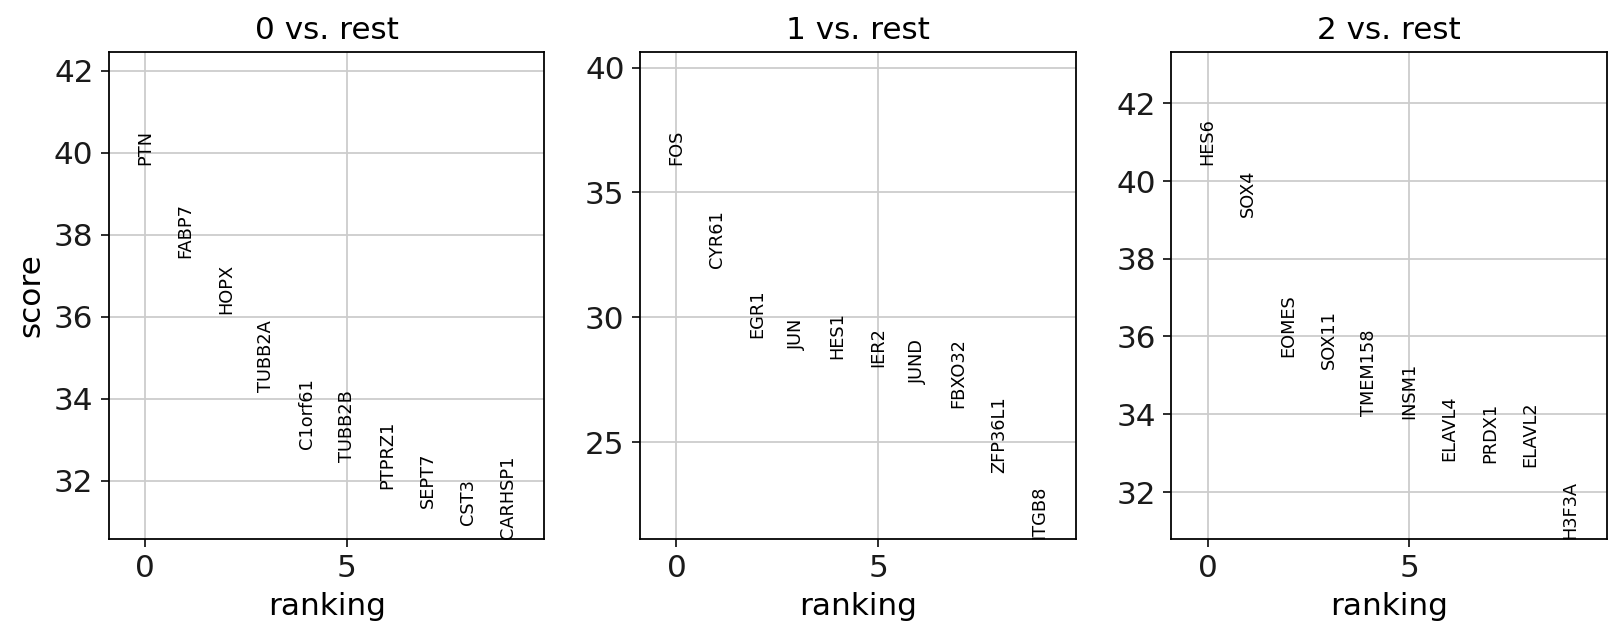

In [17]:
sc.set_figure_params(figsize=(4, 4))

sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=10, key= 'wilcoxon', sharey=False)

**Renaming leiden clustering**

In [18]:
new_cluster_names = [
    'oRG', 'vRG',
    'IP']
adata.rename_categories('leiden', new_cluster_names)

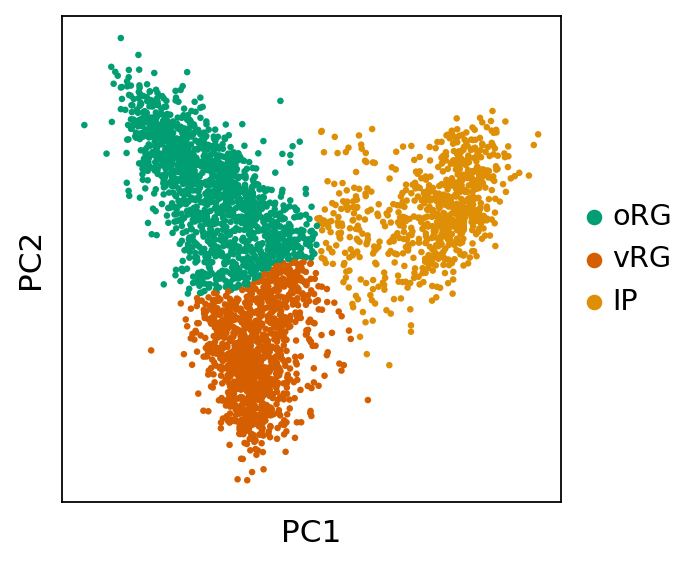

In [19]:
sc.set_figure_params(figsize=(4,4))

sc.pl.pca(adata, color='leiden', legend_loc='right margin', title='', frameon=True)

### **Computing force-directed graph**

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:16)


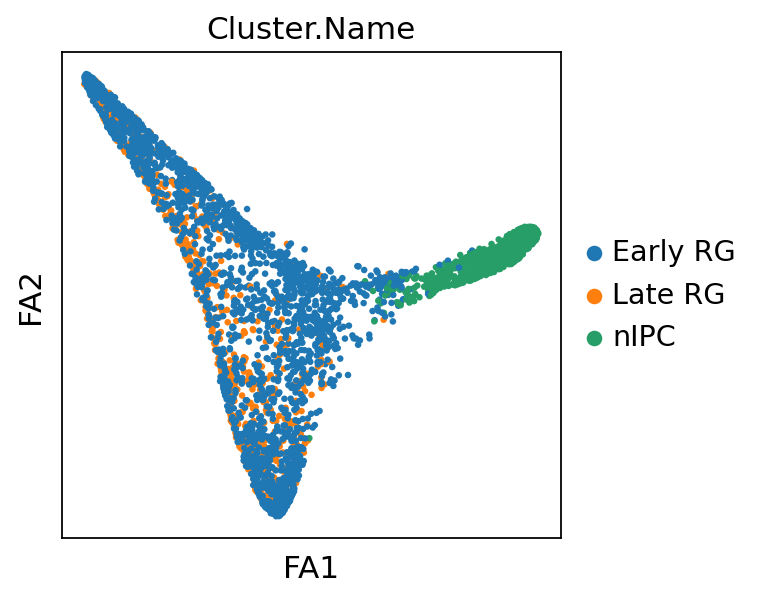

In [20]:
adata.obsm["X_pca2d"]=adata.obsm["X_pca"][:,:2]

sc.tl.draw_graph(adata,init_pos='X_pca2d')

sc.pl.draw_graph(adata, color='Cluster.Name') #Trevino et al 2021 clustering

### **Run Palantir to obtain multiscale diffusion space**

In [21]:
dm_res = palantir.utils.run_diffusion_maps(pca_projections.iloc[:,0:2])
ms_data = palantir.utils.determine_multiscale_space(dm_res,n_eigs=4)
adata.obsm["X_palantir"]=ms_data.values

Determing nearest neighbor graph...
computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


## **Tree learning with EPG** - Exploration

### **Selection of number nodes 25**

inferring a principal tree --> parameters used 
    25 principal points, mu = 0.1, lambda = 0.01
    finished (0:00:05) --> added 
    .uns['epg'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


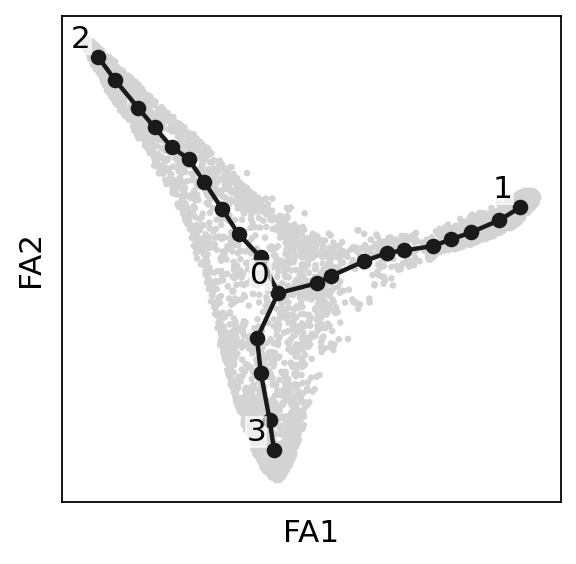

In [22]:
sc.set_figure_params(figsize=(4,4))

scf.tl.tree(adata,method="epg",Nodes=25,use_rep="palantir",
            device="cpu",seed=1)
scf.pl.graph(adata)

#### Projecting into PCA dim red

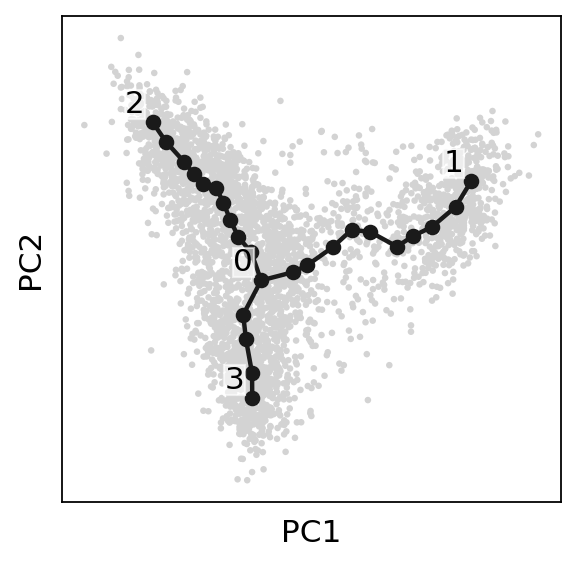

In [23]:
sc.set_figure_params(figsize=(4,4))

scf.pl.graph(adata, basis="pca")

### **Selecting a root using FOS expression and computing pseudotime**

In [24]:
adata

AnnData object with n_obs × n_vars = 3455 × 12636
    obs: 'orig.ident', 'Sample.ID', 'Age', 'Batch', 'Cluster.Name', 'percent.mt', 'percent.zeros', 'nCount_RNA', 'nFeature_RNA', 'n_counts_all', 'leiden'
    var: 'features', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'Cluster.Name_colors', 'Batch_colors', 'neighbors', 'leiden', 'leiden_colors', 'logreg', 'wilcoxon', 'draw_graph', 'graph', 'epg'
    obsm: 'X_pca', 'X_pca2d', 'X_draw_graph_fa', 'X_palantir', 'X_R'
    layers: 'raw_counts', 'raw_count'
    obsp: 'distances', 'connectivities'

In [25]:
scf.tl.root(adata,"FOS")

scf.tl.convert_to_soft(adata,1,1000) #soft assignment

scf.tl.pseudotime(adata,n_jobs=16,n_map=100,seed=42)

automatic root selection using FOS values
node 3 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
Converting R into soft assignment matrix
    finished (0:00:00) --> updated 
    .obsm['X_R'] converted soft assignment of cells to principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.
projecting cells onto the principal graph
    mappings:   0%|                                                                                                                                                                | 0/100 [00:00<?, ?it/s]

Unable to determine R library path: Command '('/opt/conda/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/opt/conda/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/opt/conda/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/opt/conda/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/opt/conda/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/opt/conda/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/opt/conda/lib/R/

    mappings: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.07it/s]
    finished (0:00:34) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


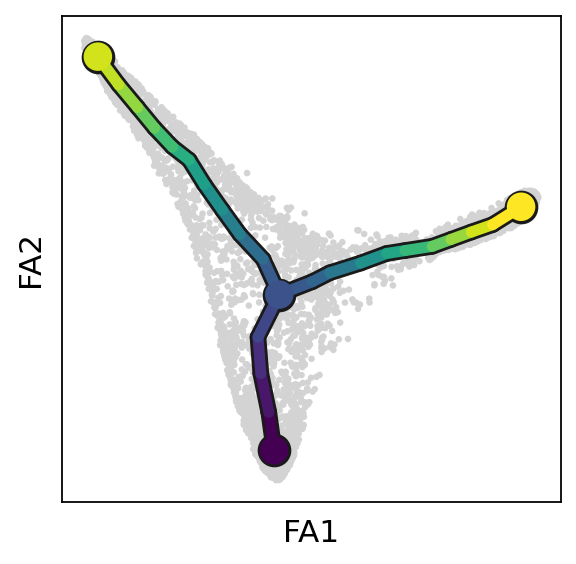

In [26]:
sc.set_figure_params(figsize=(4,4))

scf.pl.trajectory(adata)

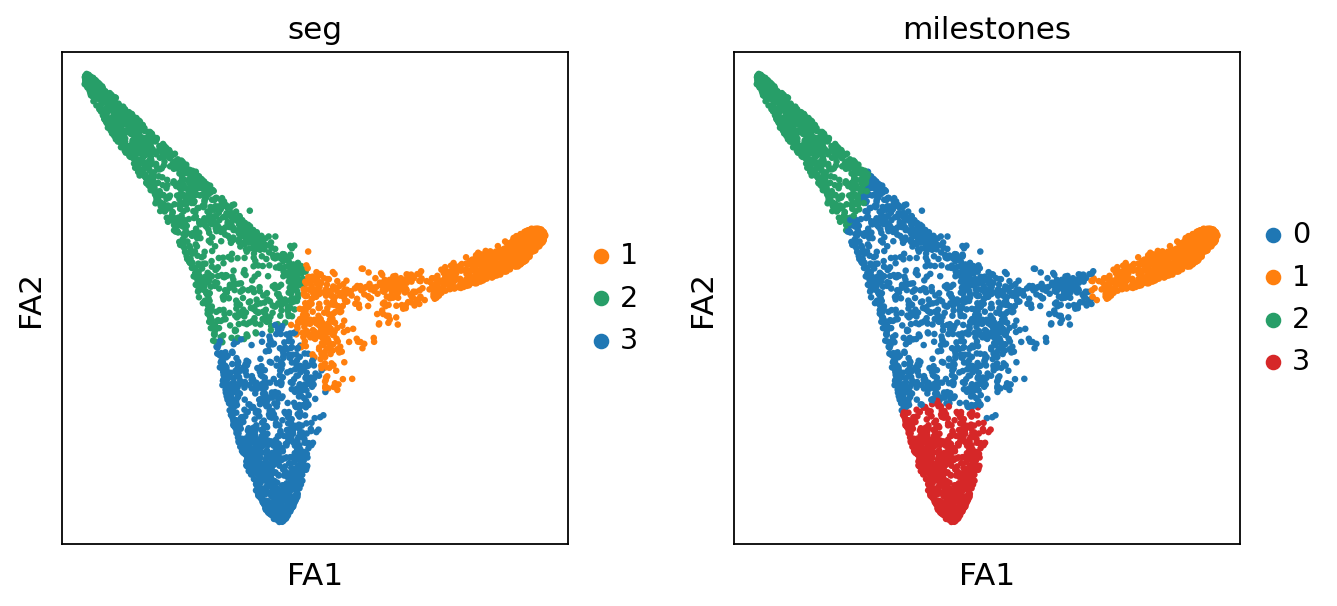

In [27]:
sc.set_figure_params(figsize=(4,4))

sc.pl.draw_graph(adata,color=["seg","milestones"]) 

In [28]:
scf.tl.rename_milestones(adata,["transient","IPC","oRG","vRG"])

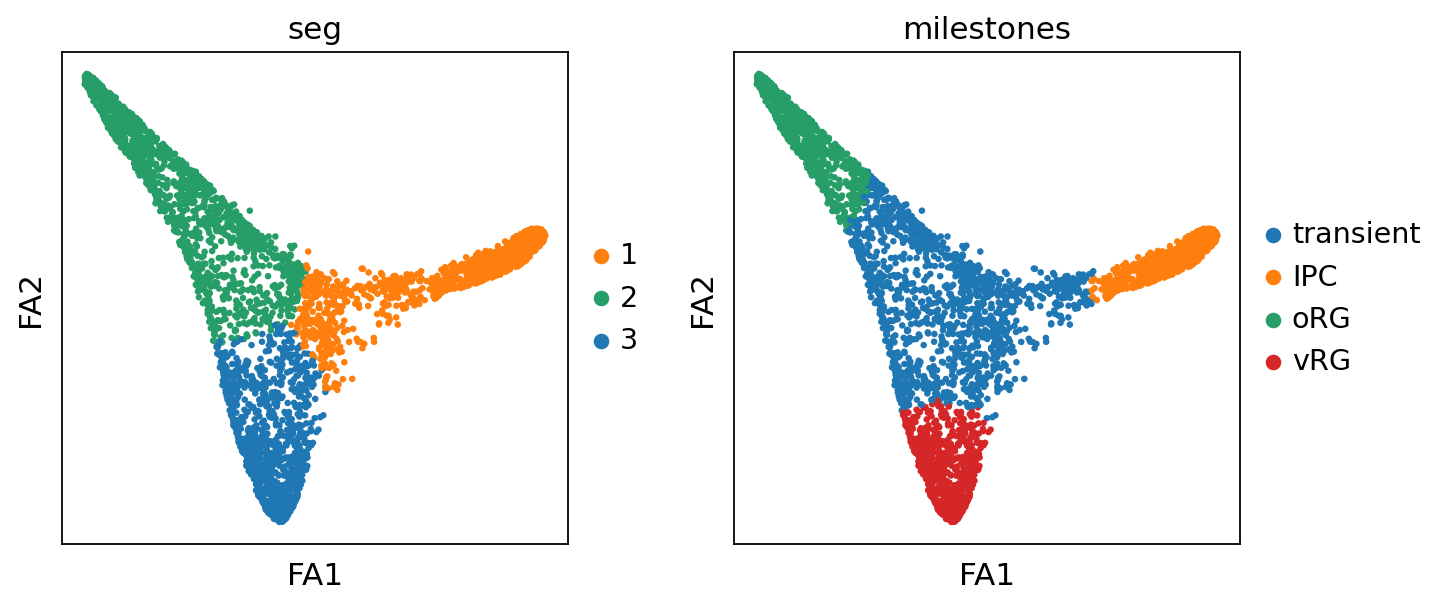

In [29]:
sc.set_figure_params(figsize=(4,4))

sc.pl.draw_graph(adata,color=["seg","milestones"])

In [30]:
#Single branch
root_to_oRG=scf.tl.subset_tree(adata,root_milestone="vRG",milestones=["oRG"],copy=True)
#
root_to_IPC=scf.tl.subset_tree(adata,root_milestone="vRG",milestones=["IPC"],copy=True)

subsetting tree
node 2 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    finished (0:00:01) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.
    finished (0:00:00) --> tree extracted
--> added 
    .obs['old_milestones'], previous milestones from intial tree
subsetting tree
node 2 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    finished (0:00:01) --> added
    .obs['edge'] assigned edge.


### **Dendrogram representation**

In [31]:
scf.tl.dendrogram(adata)

Generating dendrogram of tree
    segment : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]
    finished (0:00:03) --> added 
    .obsm['X_dendro'], new embedding generated.
    .uns['dendro_segments'] tree segments used for plotting.


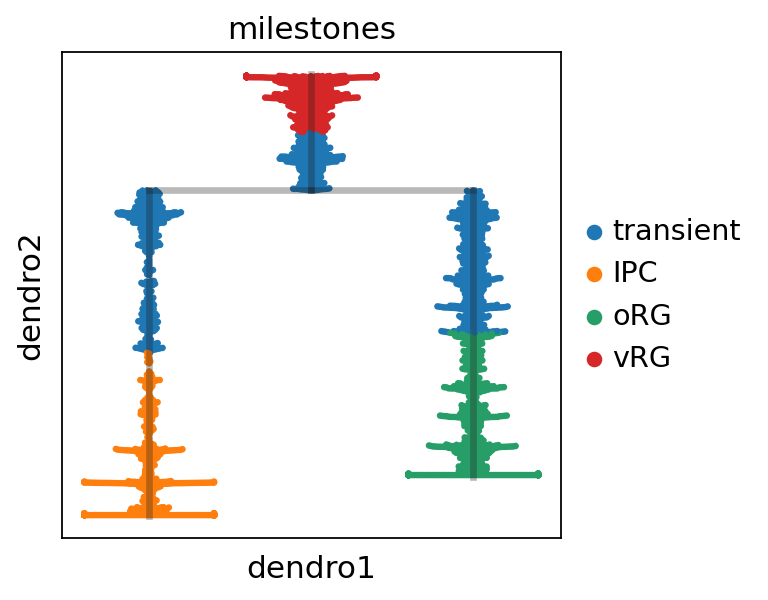

In [32]:
sc.set_figure_params(figsize=(4,4))

scf.pl.dendrogram(adata,color="milestones")

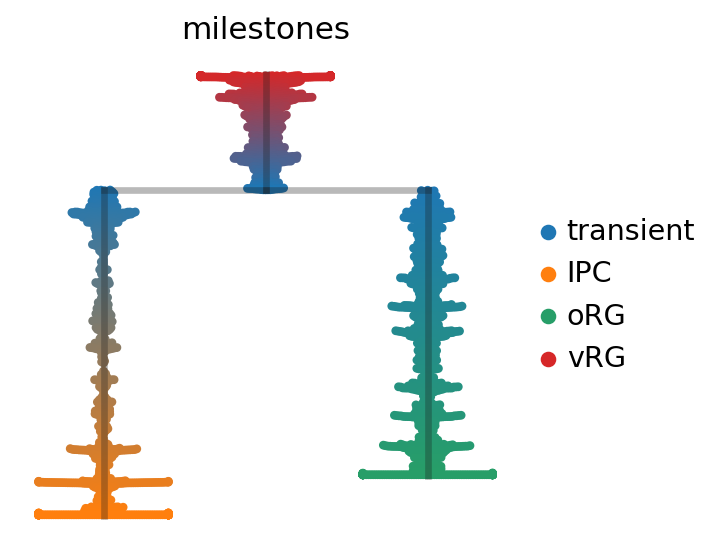

In [33]:
scf.pl.dendrogram(adata,color="milestones",legend_loc="right margin",color_milestones=True,legend_fontoutline=True, frameon=False)

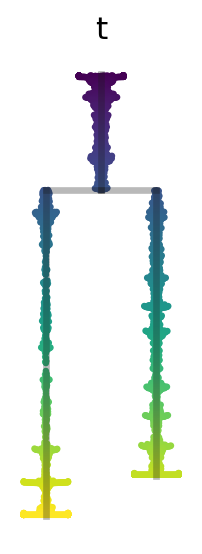

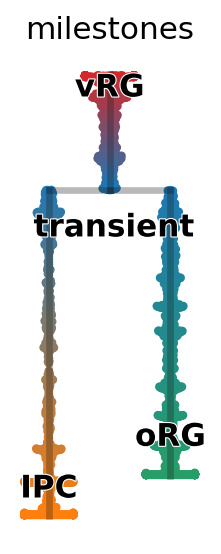

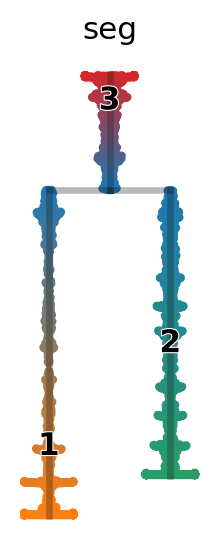

In [34]:
sc.set_figure_params(figsize=(1.5,4),frameon=False,dpi_save=300)
scf.pl.dendrogram(adata,color="t",show_info=False,cmap="viridis", save="_pseudotimeDendrogram")
scf.pl.dendrogram(adata,color="milestones",legend_loc="on data",color_milestones=True,legend_fontoutline=True, save="_milestoensDendrogram")
scf.pl.dendrogram(adata,color="seg",legend_loc="on data",color_milestones=True,legend_fontoutline=True, save="_segmentsDendrogram")

## Test and fit features associated with the tree

Let's find out which genes are significantly changing along the tree.

In [35]:
scf.tl.test_association(adata,n_jobs=16, A_cut=0.8)

test features for association with the trajectory
    single mapping : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12636/12636 [03:11<00:00, 65.95it/s]
    found 233 significant features (0:03:11) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


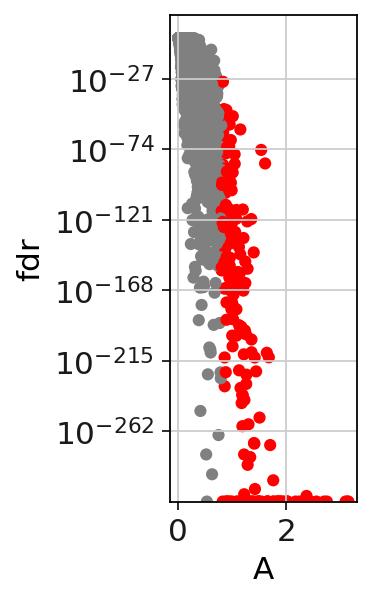

In [36]:
scf.pl.test_association(adata)

In [37]:
adata.var[adata.var['signi'] == True].index #significant genes n=233

Index(['HES4', 'RPL22', 'STMN1', 'MARCKSL1', 'RPS8', 'PRDX1', 'NASP', 'ELAVL4',
       'LRP8', 'PPAP2B',
       ...
       'SEPW1', 'RPS11', 'RPS9', 'TTYH1', 'RPS5', 'RPL3', 'LINC00478',
       'MT-CO1', 'MT-CO2', 'MT-CO3'],
      dtype='object', length=233)

In [38]:
scf.tl.fit(adata,n_jobs=16)

fit features associated with the trajectory
    single mapping : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 233/233 [00:10<00:00, 22.54it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:10) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


<AxesSubplot: title={'center': 'seg'}, xlabel='FA1', ylabel='FA2'>

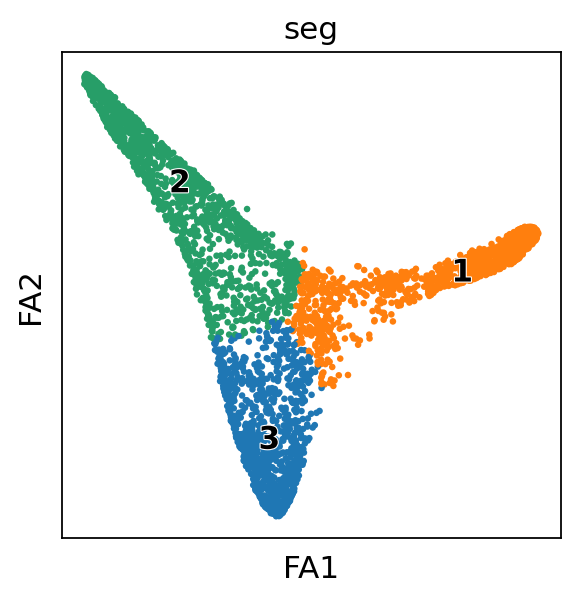

In [39]:
sc.set_figure_params()

sc.pl.draw_graph(adata,color=["seg"],legend_loc="on data",show=False,legend_fontoutline=True)

In [40]:
adata.obs['segmentation'] = np.select([adata.obs['seg'] == '1', adata.obs['seg'] == '3'],
                            ['s_IPC',  's_vRG'], 
                            default='s_oRG')

In [41]:
!ls /home/jovyan/jm_jlab/data_indNeuro/scFates_output

polioudakis19_scFates_clustering.tsv  scFates_object.h5ad
scFates_clustering.tsv


### **Saving for later analysis**

#### Plotting specific markers

In [42]:
pd.DataFrame(adata.var_names).to_csv("/home/jovyan/jm_jlab/data_indNeuro/scFates_test_gene_tree.tsv", sep='\t', index=False, header=None)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

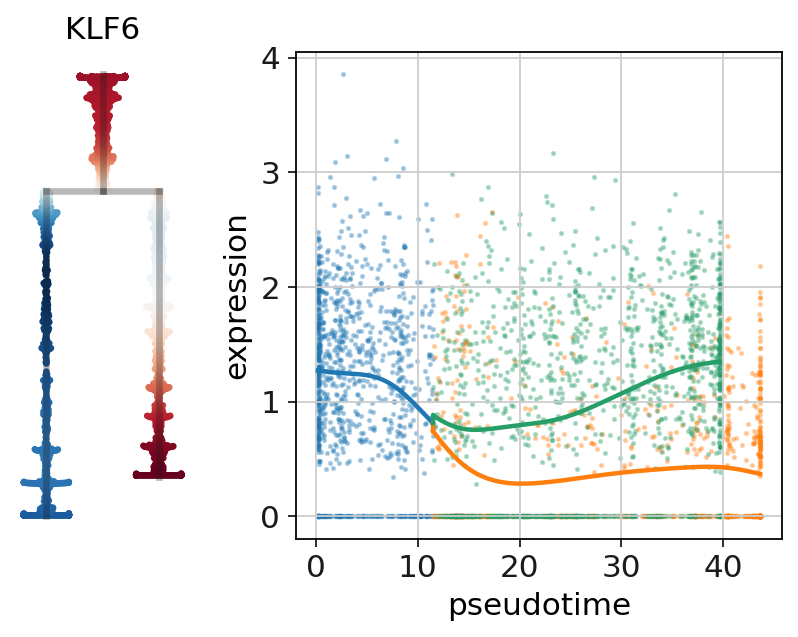

In [43]:
sc.set_figure_params(figsize=(.8,4),frameon=False)
scf.set_figure_pubready()
scf.pl.single_trend(adata,"KLF6",basis="dendro",wspace=-.25)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

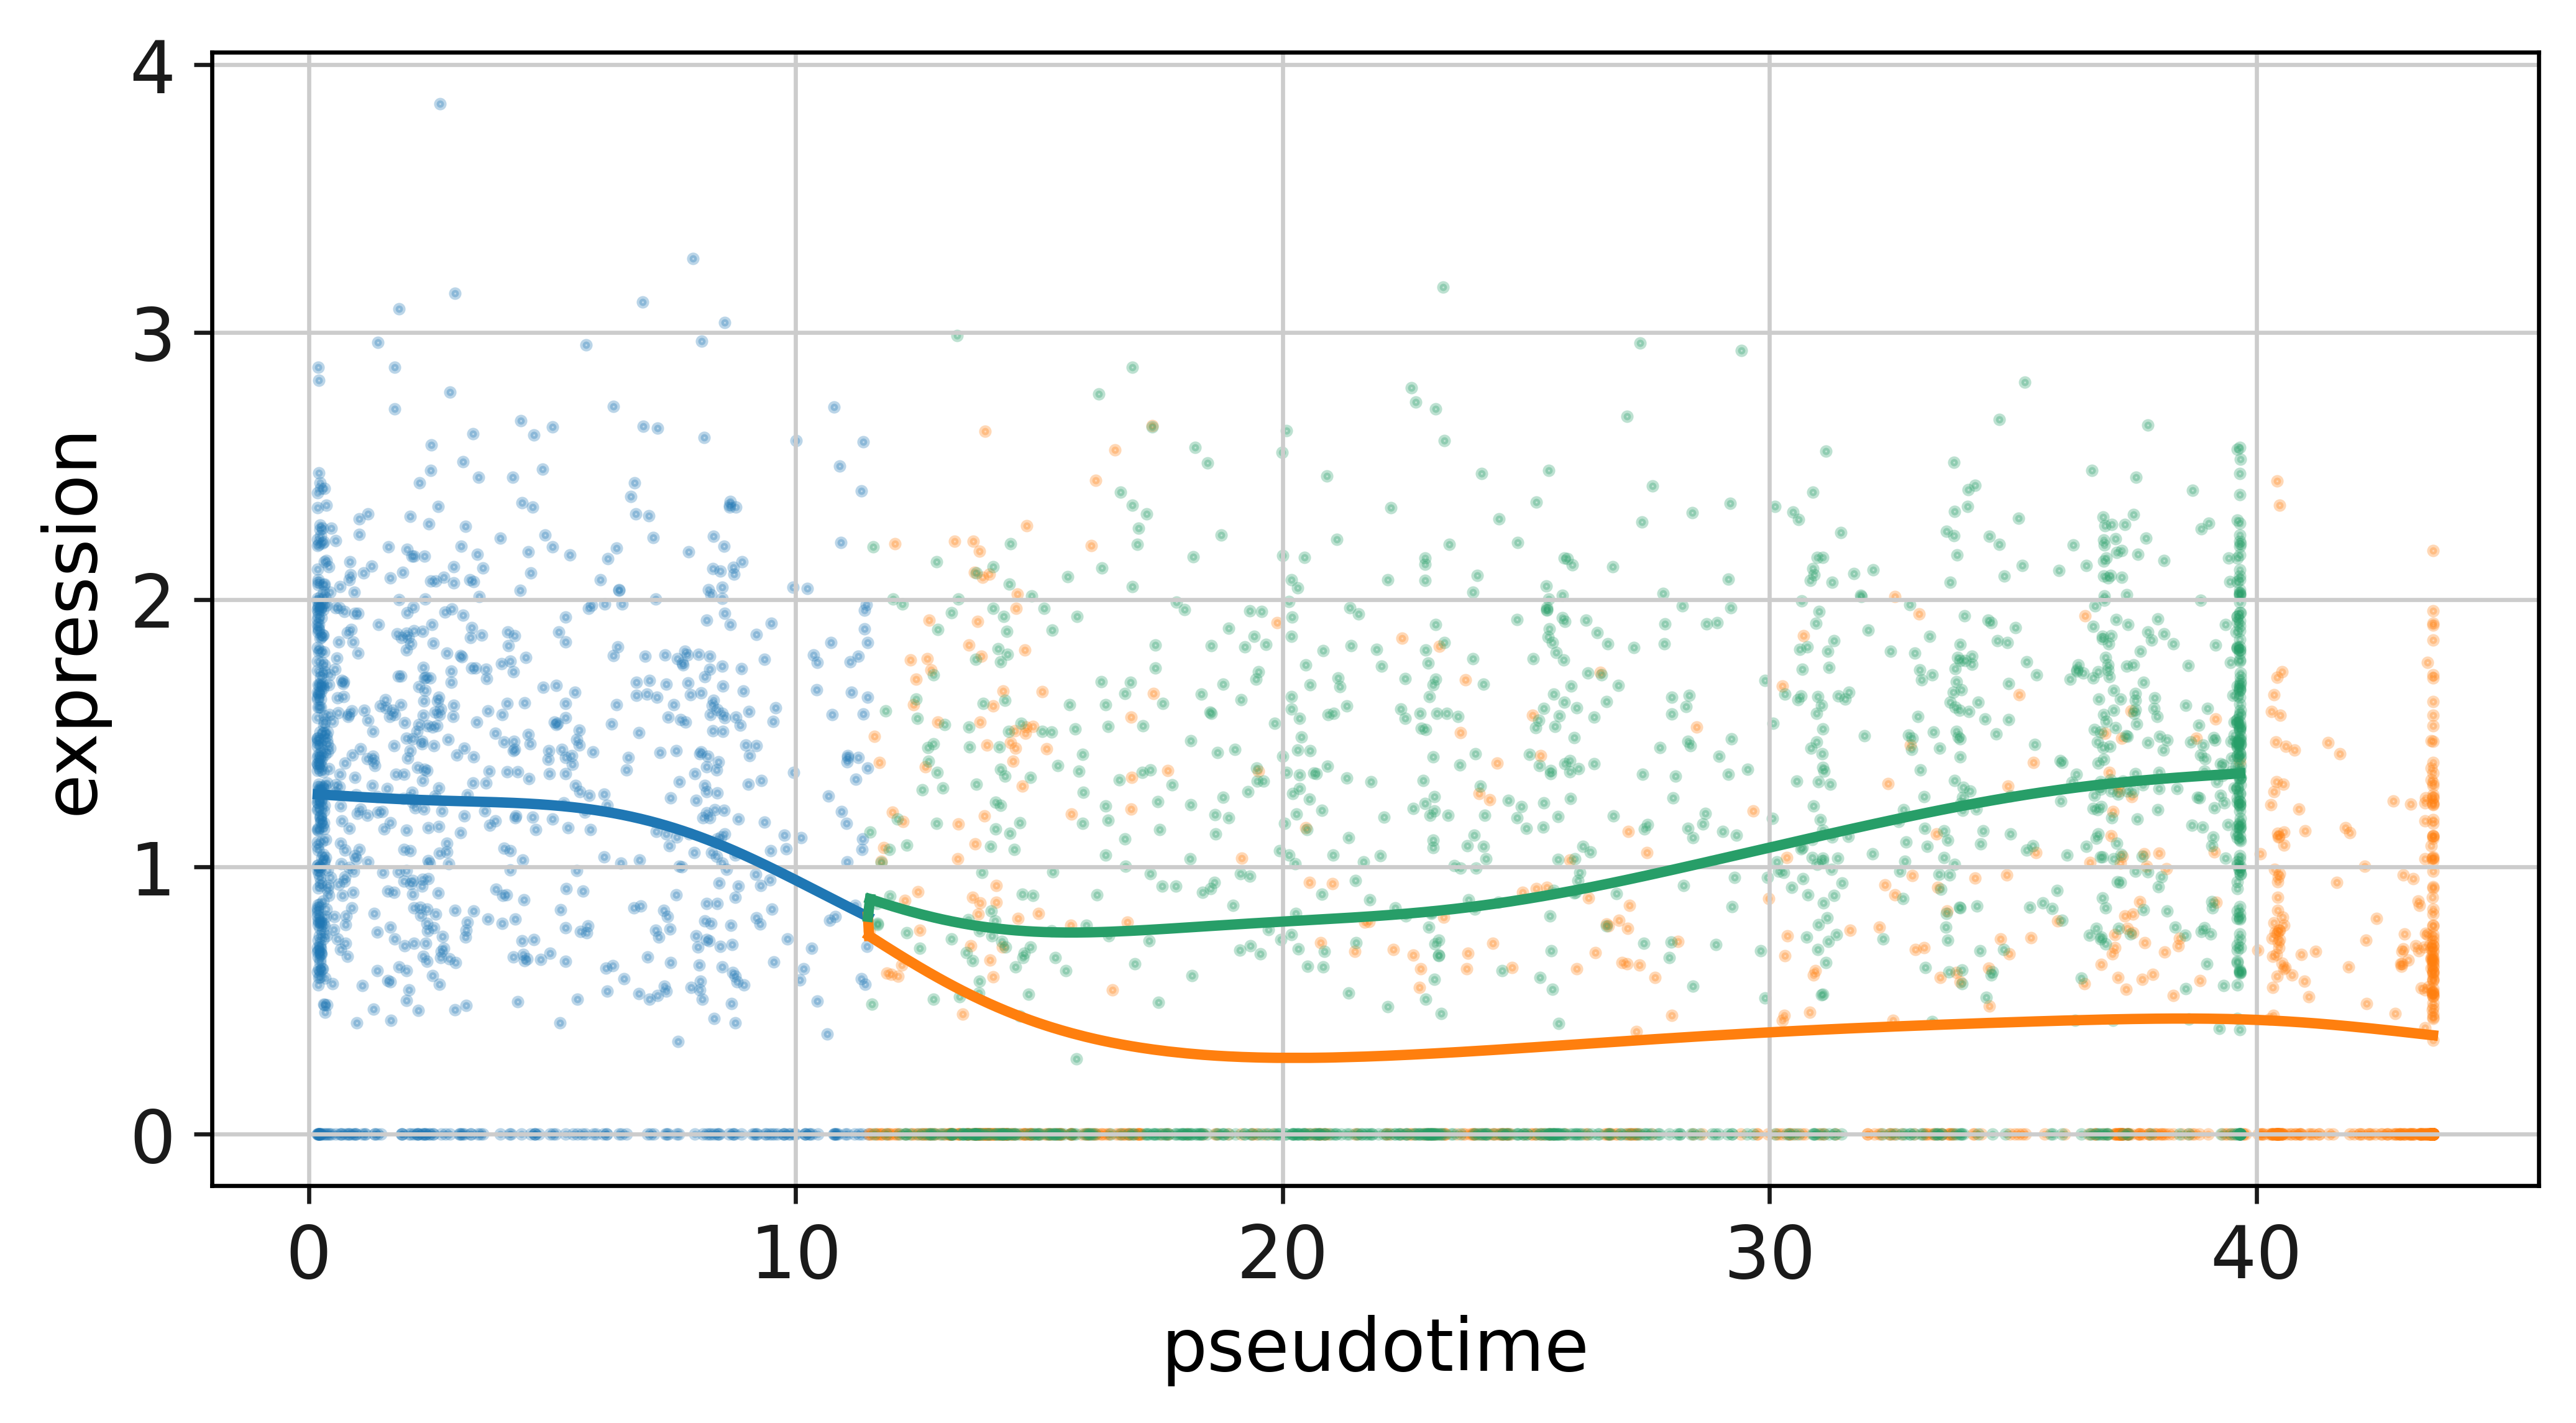

In [47]:
sc.set_figure_params(figsize=(5,3),frameon=False,dpi=300)
scf.set_figure_pubready()
scf.pl.single_trend(adata,"KLF6",basis="dendro",wspace=-.25, plot_emb=False, save="KLF6_t.png")

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

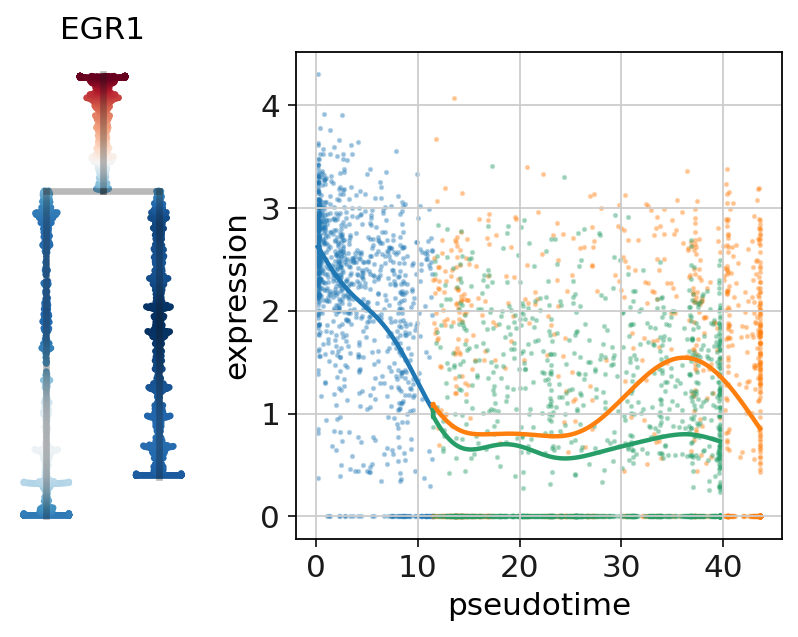

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

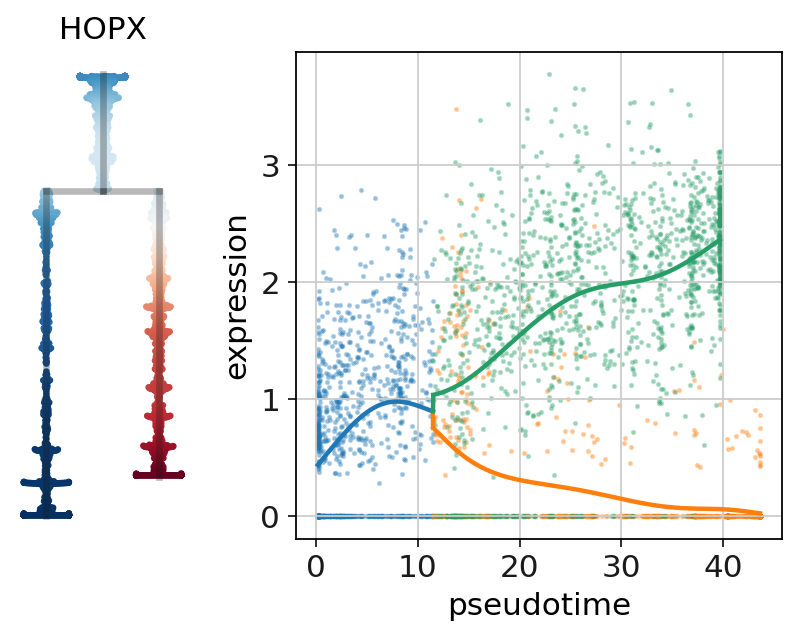

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

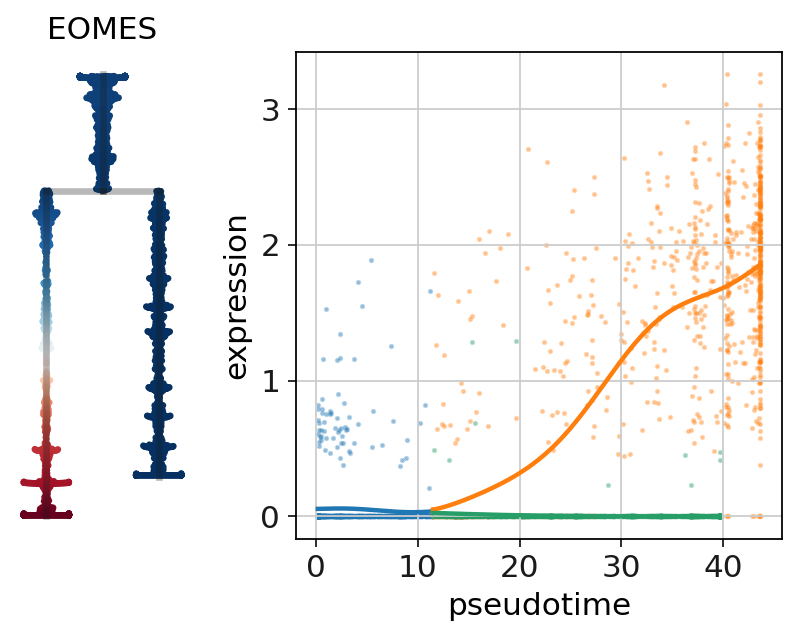

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

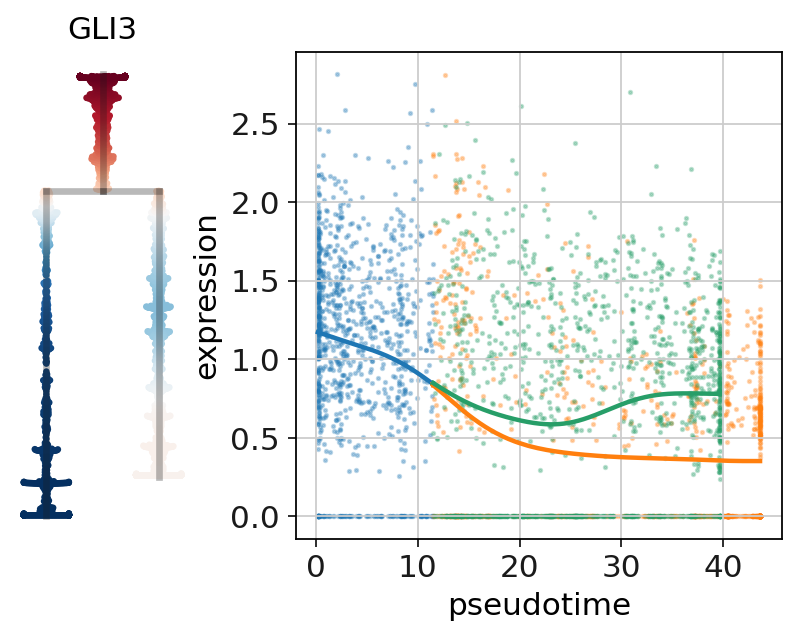

In [88]:
sc.set_figure_params(figsize=(.8,4),frameon=False)
scf.set_figure_pubready()
scf.pl.single_trend(adata,"EGR1",basis="dendro",wspace=-.25)
scf.pl.single_trend(adata,"HOPX",basis="dendro",wspace=-.25)
scf.pl.single_trend(adata,"EOMES",basis="dendro",wspace=-.25)
scf.pl.single_trend(adata,"GLI3",basis="dendro",wspace=-.25)

In [33]:
adata.layers['fitted'].shape

(3455, 233)

In [219]:
plot_fig1_data = adata[:,adata.var['highly_variable']].copy()

In [262]:
plot_fig1_data2 = plot_fig1_data[:,plot_fig1_data.var.sort_values(by='highly_variable_rank').head(20).index].copy()

In [263]:
plot_fig1_df =  pd.DataFrame(np.log1p(plot_fig1_data2.layers['raw_counts'].todense()), columns=plot_fig1_data2.var_names, index=plot_fig1_data2.obs['t']).sort_index()

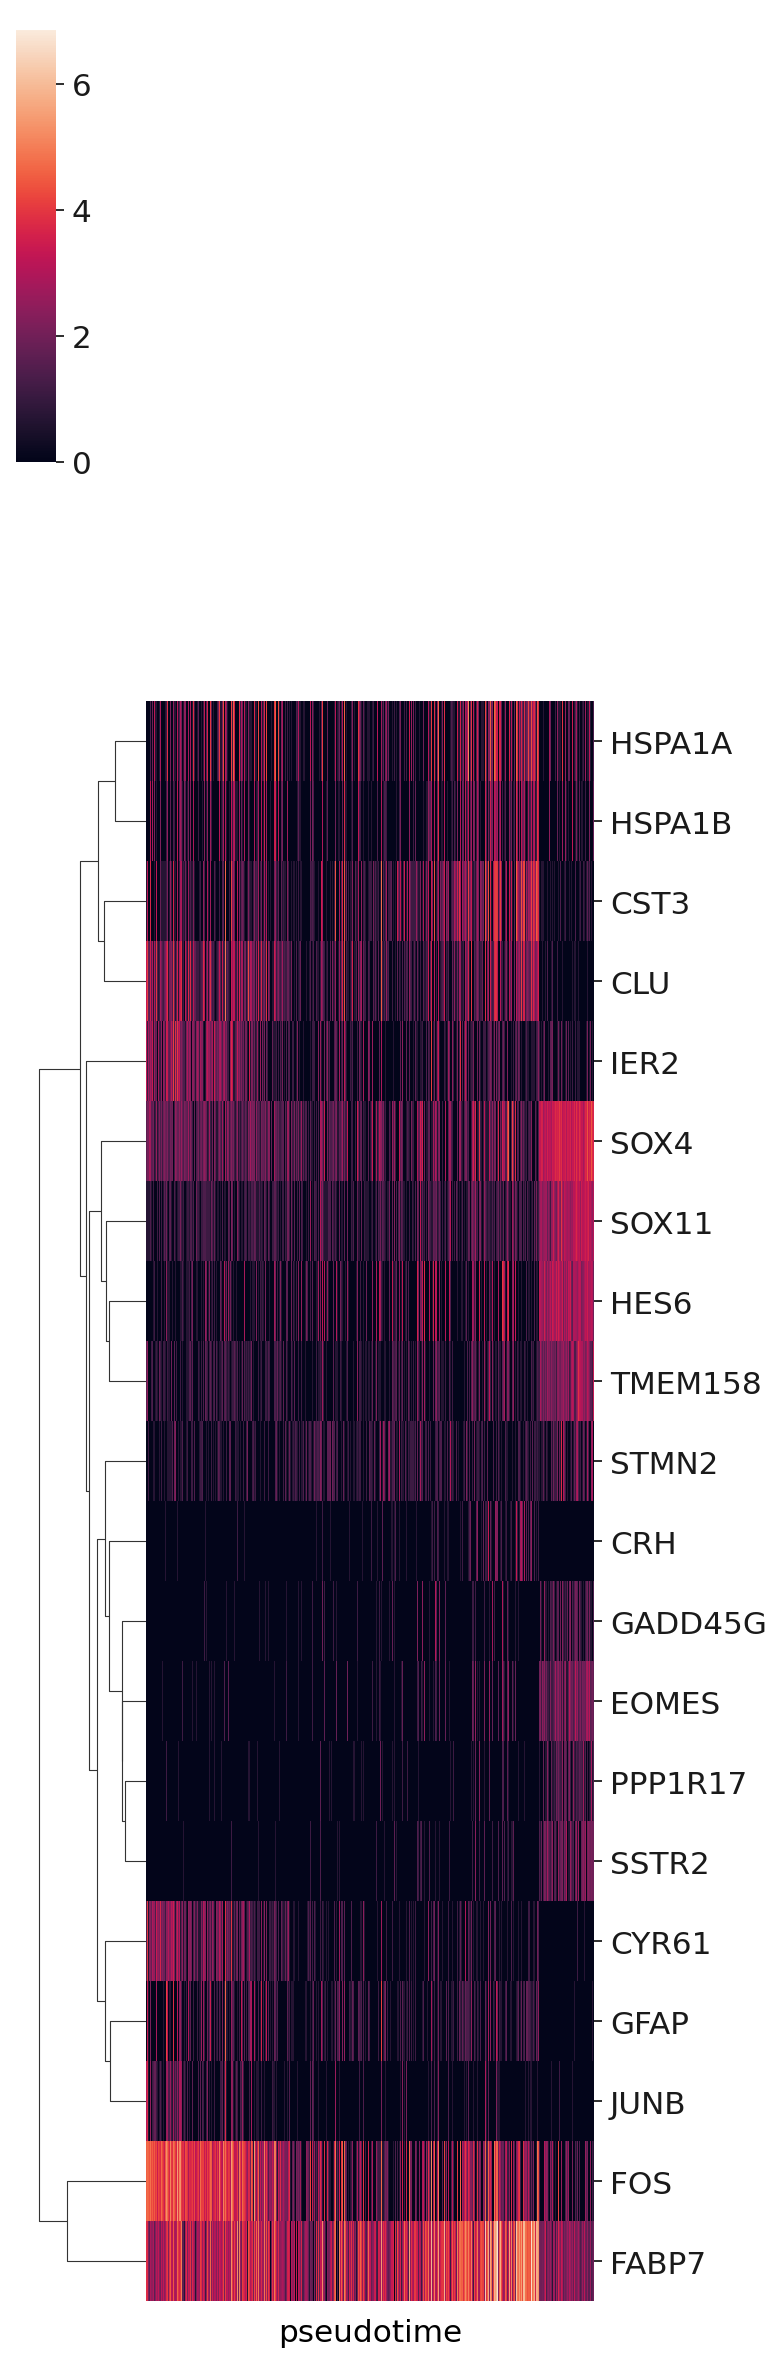

In [291]:
g = sns.clustermap(plot_fig1_df.transpose(), figsize=(5, 15), row_cluster=True,col_cluster=False, xticklabels=False, dendrogram_ratio=(.2, .3))
ax = g.ax_heatmap
ax.set_xlabel("pseudotime")
ax.set_ylabel("")
plt.savefig("/home/jovyan/jm_jlab/test.png",dpi=300)

## **Final plots**

In [ ]:
figures_path

Text(0.5, 0, '')

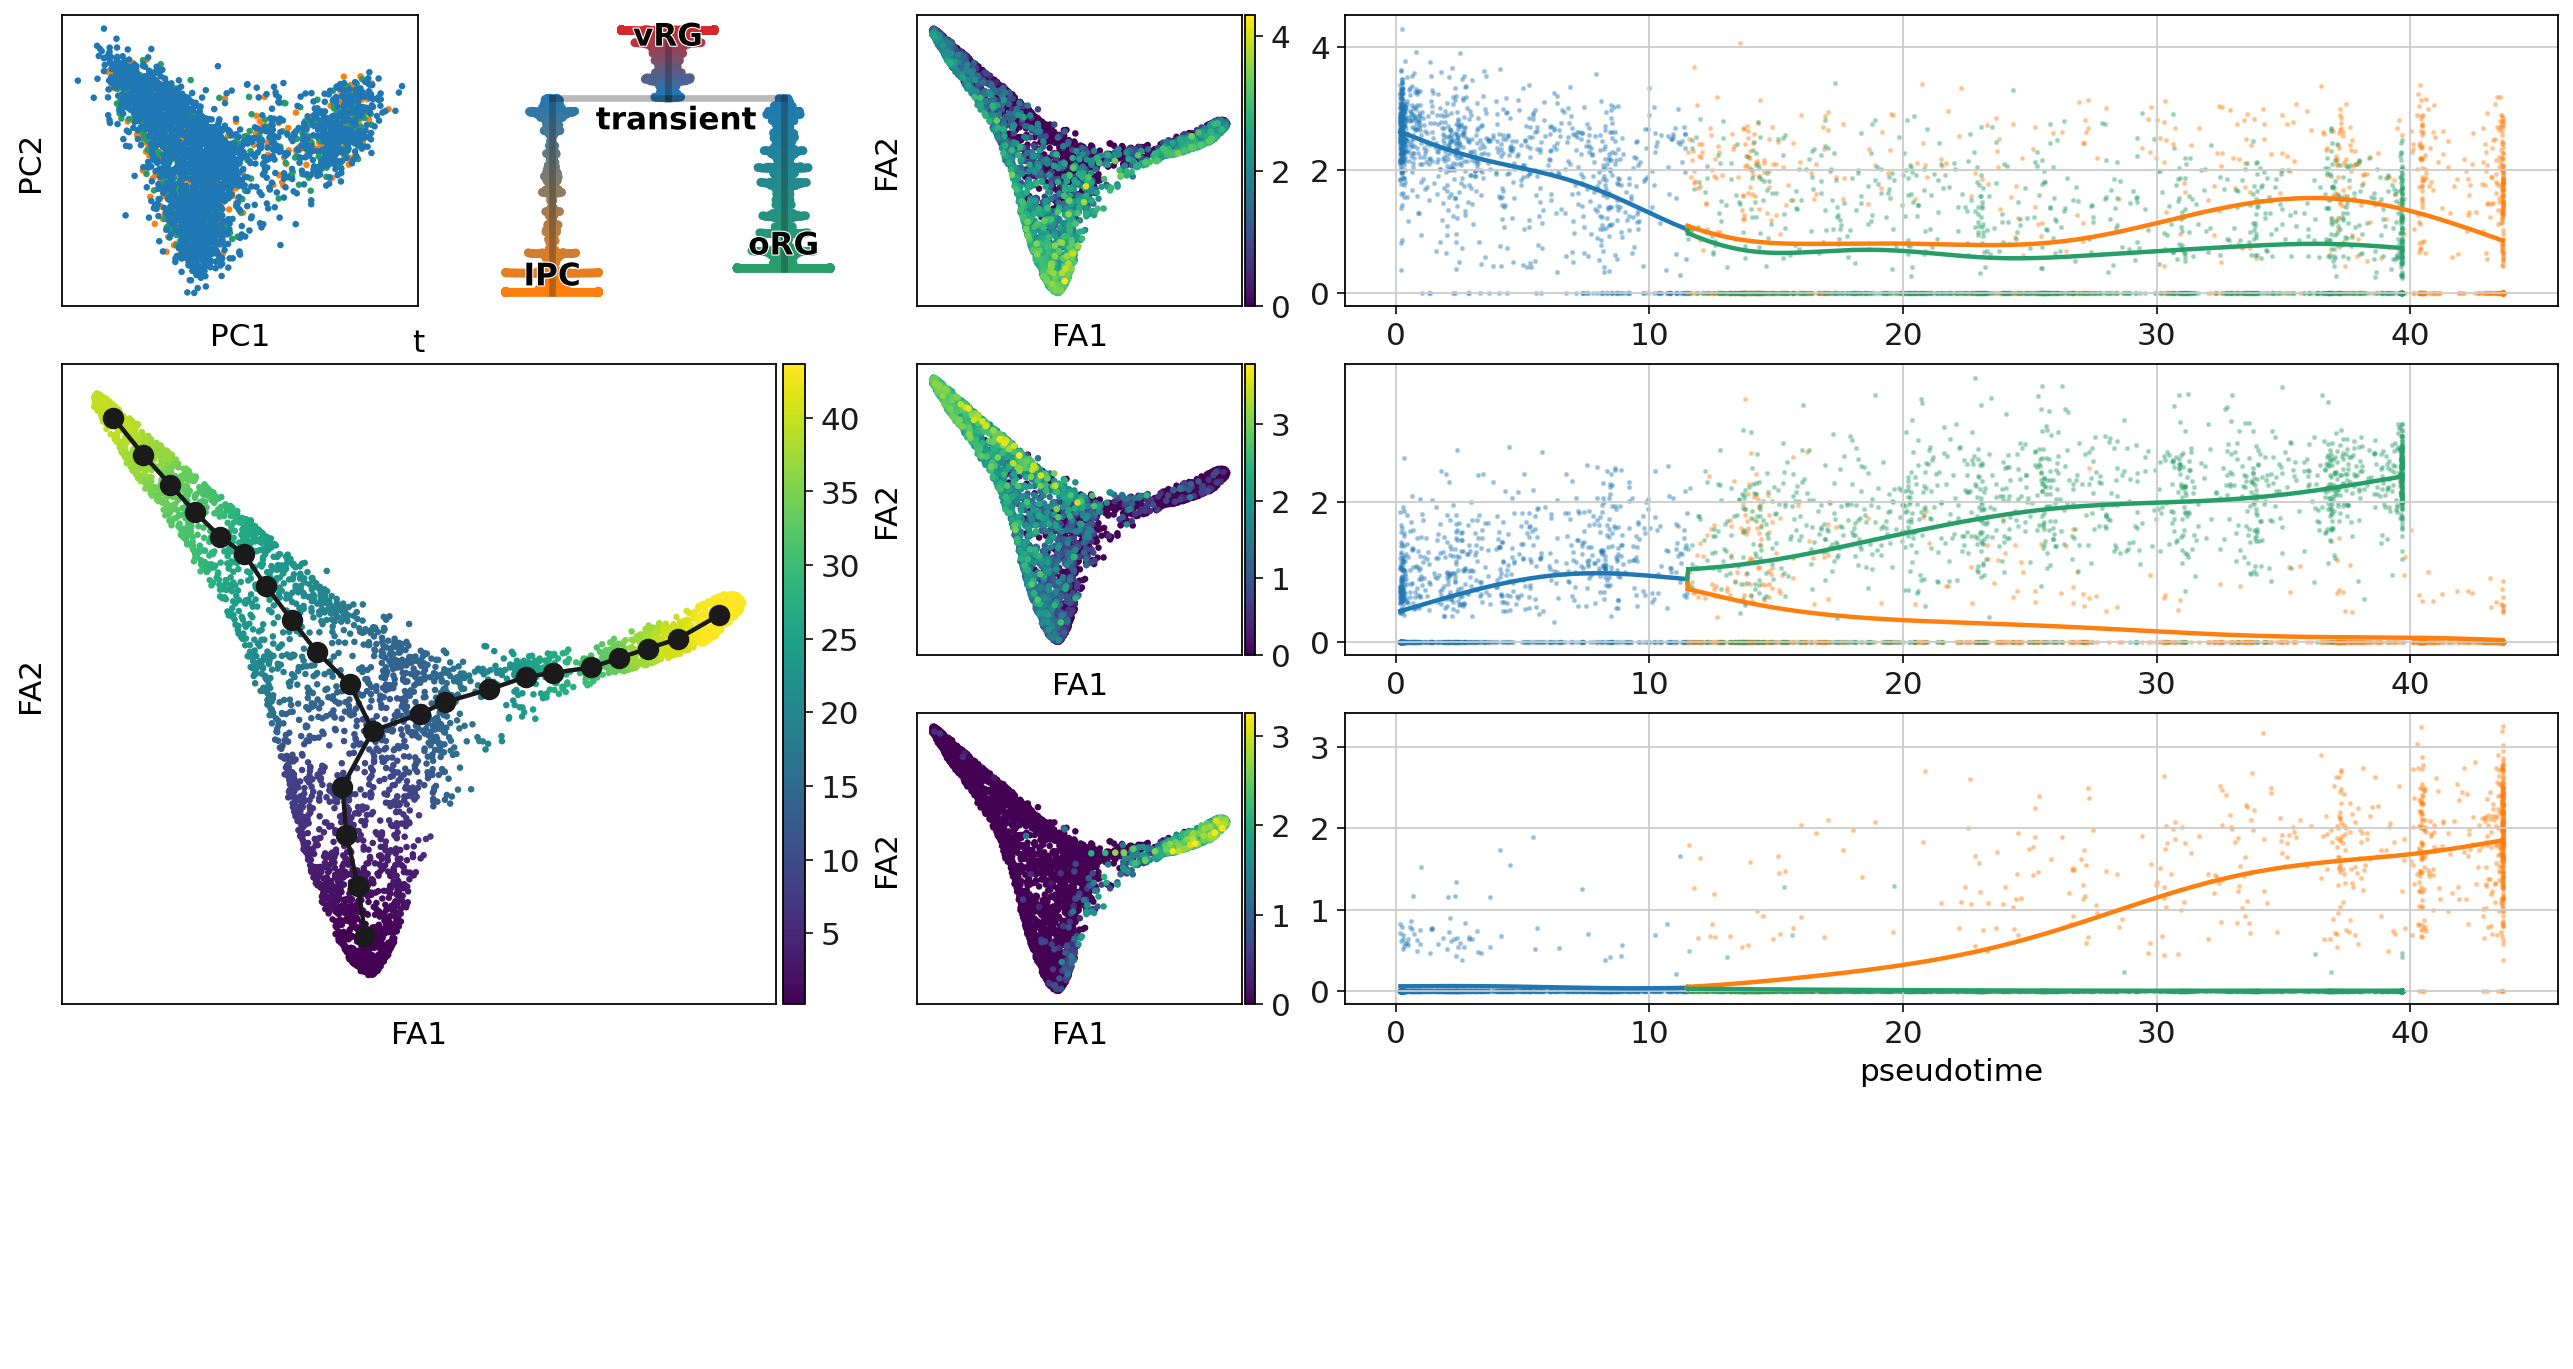

In [ ]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(20, 11),dpi_save=300)

fig=plt.figure()

gs=GridSpec(4,6)


ax0=fig.add_subplot(gs[0,0:1])
ax1=fig.add_subplot(gs[1:3,0:2])
ax2=fig.add_subplot(gs[0,1:2])
ax3=fig.add_subplot(gs[3:4,0:1])
ax33=fig.add_subplot(gs[3:4,1:2])

ax20=fig.add_subplot(gs[0,2:3]) 
ax21=fig.add_subplot(gs[1,2:3]) 
ax22=fig.add_subplot(gs[2,2:3]) 

ax5=fig.add_subplot(gs[0,3:6])
#ax5.set_title('ax1 title')

ax6=fig.add_subplot(gs[1,3:6])
ax7=fig.add_subplot(gs[2,3:6])

# PCA plot

sc.pl.pca(adata, color=["Age"],  frameon=True, ax=ax0, show=False, title="", legend_loc=None)

scf.pl.dendrogram(adata,color="milestones",ax=ax2, legend_loc="on data", frameon=False, show=False, color_milestones=True,legend_fontoutline=True, title="")


scf.pl.graph(adata,basis="draw_graph_fa", ax=ax1,
             color_cells=['t'], forks=False, tips=False, show=False, size_nodes=75 )

ax3.axis('off')
ax33.axis('off')


sc.pl.draw_graph(adata, color='EGR1', ax=ax20, show=False, title="") 
sc.pl.draw_graph(adata, color='HOPX', ax=ax21, show=False, title="") 
sc.pl.draw_graph(adata, color='EOMES', ax=ax22, show=False, title="") 


scf.pl.single_trend(adata,"EGR1",basis="dendro", ax_trend=ax5, wspace=-.25, ylab=None, title=False, plot_emb=False, show=False)
scf.pl.single_trend(adata,"HOPX",basis="dendro", ax_trend=ax6, wspace=-.25, ylab=None, title=True, plot_emb=False, show=False)
scf.pl.single_trend(adata,"EOMES",basis="dendro", ax_trend=ax7, wspace=-.25, ylab=None, title=True, plot_emb=False, show=False)

ax5.set_xlabel('')
ax6.set_xlabel('')
ax6.set_xlabel('')

#fig.savefig(figures_path+'Fig1.pdf',dpi=300)

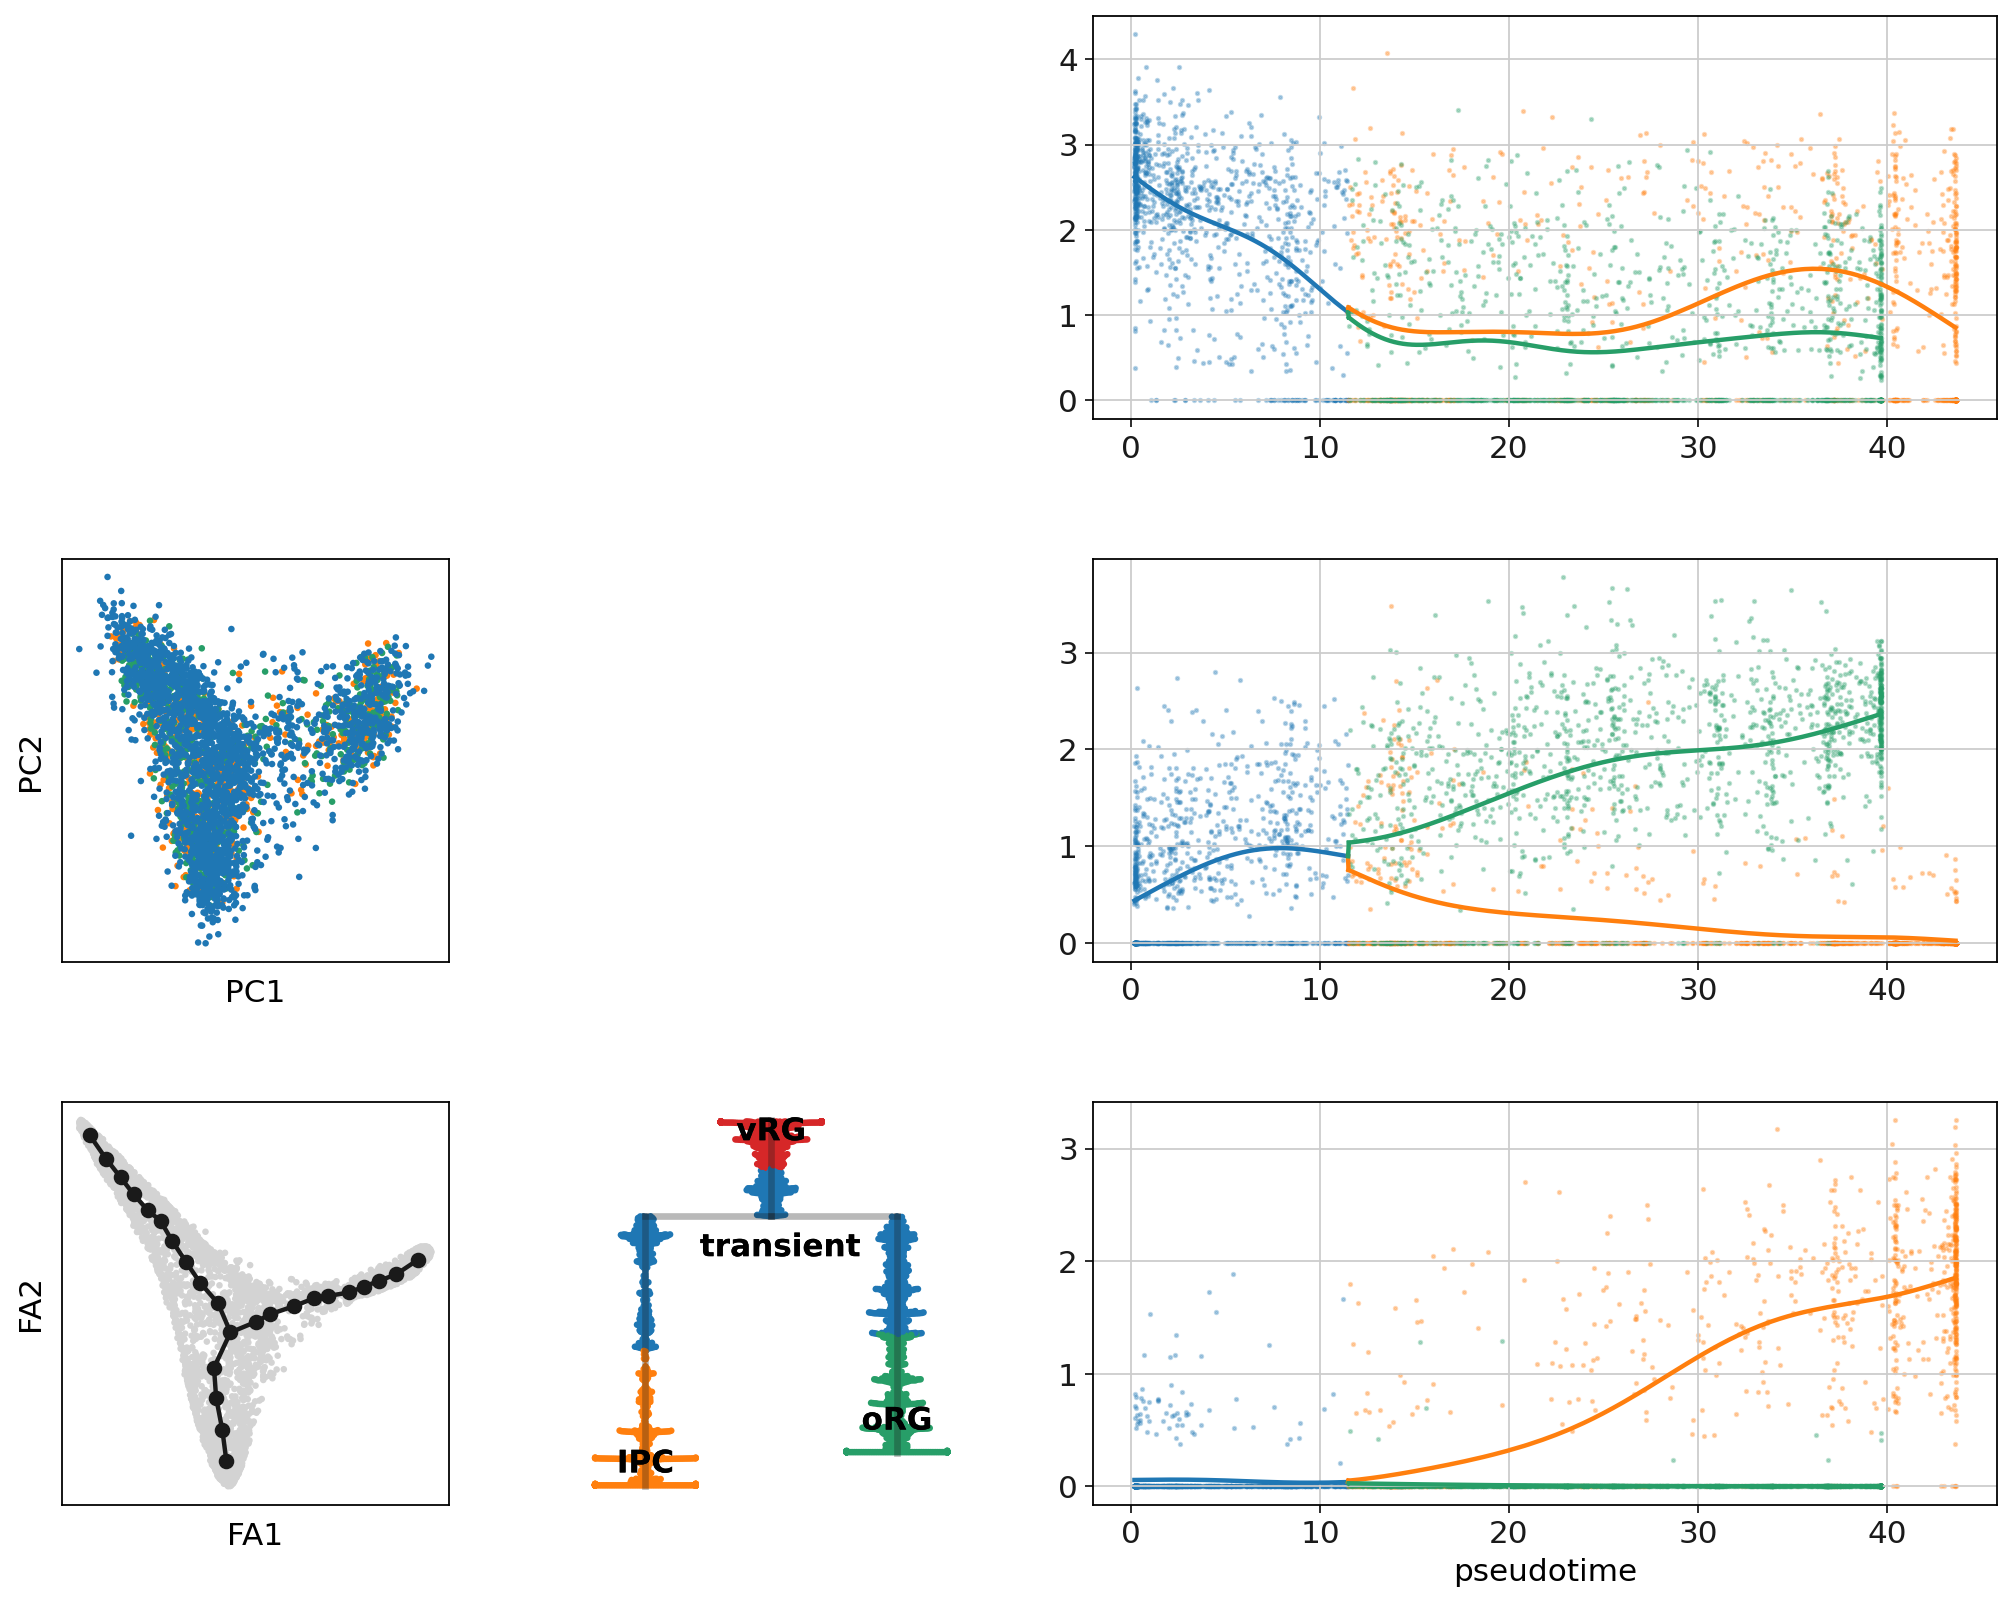

In [293]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(20, 11),dpi_save=300)

fig=plt.figure()

gs=GridSpec(3,6)


ax0=fig.add_subplot(gs[0,0:1])
ax1=fig.add_subplot(gs[1:2,0:1])
ax2=fig.add_subplot(gs[0,1:2])
ax3=fig.add_subplot(gs[2:3,0:1])
ax33=fig.add_subplot(gs[2:3,1:2])

#ax20=fig.add_subplot(gs[0,2:3]) 
#ax21=fig.add_subplot(gs[1,2:3]) 
#ax22=fig.add_subplot(gs[2,2:3]) 

ax5=fig.add_subplot(gs[0,2:4])
#ax5.set_title('ax1 title')

ax6=fig.add_subplot(gs[1,2:4])
ax7=fig.add_subplot(gs[2,2:4])


# Space for summary strategy
ax0.axis('off')
ax2.axis('off')

# PCA plot
sc.pl.pca(adata, color=["Age"],  frameon=True, ax=ax1, show=False, title="", legend_loc=None)


# Bottom left
scf.pl.graph(adata,basis="draw_graph_fa", ax=ax3, forks=False, tips=False, show=False)

scf.pl.dendrogram(adata,color="milestones",ax=ax33, legend_loc="on data", frameon=False, show=False, color_milestones=False,legend_fontoutline=False, title="")


#ax20.axis('off')
#ax21.axis('off')
#ax22.axis('off')


scf.pl.single_trend(adata,"EGR1",basis="dendro", ax_trend=ax5, wspace=-.25, ylab=None, title=False, plot_emb=False, show=False)
scf.pl.single_trend(adata,"HOPX",basis="dendro", ax_trend=ax6, wspace=-.25, ylab=None, title=True, plot_emb=False, show=False)
scf.pl.single_trend(adata,"EOMES",basis="dendro", ax_trend=ax7, wspace=-.25, ylab=None, title=True, plot_emb=False, show=False)

ax5.set_xlabel('')
ax6.set_xlabel('')
ax6.set_xlabel('')

fig.tight_layout(pad=3.0)
 
fig.savefig(figures_path+'Fig1.pdf',dpi=300)